In [49]:
from PID import *
import matplotlib.pyplot as plt 
import optuna
import tensorflow
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, GRU, Input
import numpy as np 
import openpyxl
from tqdm.notebook import tqdm
from openpyxl import Workbook, load_workbook

In [99]:
class Scaler:
    def __init__(self):
        self.min_vals: list[float] = None
        self.max_vals: list[float] = None

    def fit(self, X_train):
        
        self.min_vals = np.empty(X_train.shape[-1])
        self.max_vals = np.empty(X_train.shape[-1])
        
        for s in range(X_train.shape[-1]):
            self.min_vals[s] = np.min(X_train[:,:,s])
            self.max_vals[s] = np.max(X_train[:,:,s])
            
        return

    def transform(self, X):
        try:
            X_copy = np.copy(X)
            for s in range(X_copy.shape[-1]):
                X_copy[:,:,s] = (X[:,:,s] - self.min_vals[s]) / (self.max_vals[s] - self.min_vals[s])
        except:
            raise Execption("Not Fited!!!")
            
        return X_copy

    def __str__(self):
        return f"min_vals:{self.min_vals}\nmax_vals:{self.max_vals}"

    def __call__(self,X):
        return self.transform(X) 


        
def data_to_X_Y(data, window_size=2):
    
    x = []
    y = []
    
    for i in range(len(data) - window_size):
        row = [r for r in data[i:i+window_size]]  
        x.append(row)
        label = data[i+window_size][-1]
        y.append(label)
    return np.array(x), np.array(y)
        
def create_model(params: dict):
    """
    Function that automates the creation of a model based
    on the params input
    """
    
    n = params["nhidden"]
    fun1 = params["activation1"]
    l1 = params["l1"]
    l2 = params["l2"]
    dropout_rate = params["dropout_rate"]
    
    model = Sequential()
    model.add(Input((None, 3)))
    model.add(GRU(n,activation=fun1, kernel_regularizer=keras.regularizers.L1L2(l1=l1, l2=l2)))
    model.add(keras.layers.Dropout(dropout_rate))
    model.add(Dense(1))

    model.compile(
        loss = "mse",
        optimizer = keras.optimizers.Adam(learning_rate=0.001)
    )

    return model

def get_offline_error(k, model):
    dt = 0.5

    test = dataset_test[200:500]
    t_sim = t2[200:500]
    
    Y_off = test[:, -1]
    Y_pred = np.empty(t_sim.shape[0])
    
    Y_pred[0] = Y_off[0]
    U_off = test[:, :-1]
    
    
    Y_pred[: k + 1] = Y_off[: k + 1]
    
    for n in range(k, t_sim.shape[0] - 1):
        data_input = np.column_stack((U_off[n - k : n], Y_pred[n - k : n]))
        model_input = pre(data_input.reshape(-1, k, 3))
        Y_pred[n + 1] = float(model.predict(model_input, verbose=0)[0,0])

    score = mse(Y_off, Y_pred)
    return score

def mse(y1, y2):
    return np.mean(np.square(y1 - y2))

def tuna_obj(trial):

    # Decision variables
    n = trial.suggest_int('n_hidden', 1, 50)
    fun1 = trial.suggest_categorical("activation function", ["tanh", "linear"])
    window_size = trial.suggest_int("window_size", 1, 4)
    tuna_params = {
        "nhidden": n,
        "activation1": fun1,
        "window_size": window_size,
        "l1": trial.suggest_float("l1", 1e-9, 1e-2, log=True),
        "l2": trial.suggest_float("l2", 1e-9, 1e-2, log=True),
        "dropout_rate": trial.suggest_float("dr", 0.0, 0.5, step=.01),
    }
    
    tuna_model = create_model(tuna_params)

    x_tuna, y_tuna = data_to_X_Y(dataset_train, window_size = window_size)
    pre.fit(x_tuna)
    pid_x, pid_y = data_to_X_Y(pid11[:,1:], window_size)
    pid_x2, pid_y2 = data_to_X_Y(pid12[:,1:], window_size)
    pid_xfull = np.vstack([pid_x, pid_x2])
    pid_yfull = np.concatenate([pid_y, pid_y2])
    xN = pre(x_tuna)
    # fit model
    callback = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
    tuna_model.fit(xN, y_tuna, validation_split=0.25, batch_size=64, epochs=40, callbacks=[callback],verbose=0)
    final_loss = tuna_model.history.history["loss"][-1]
    final_val_loss = tuna_model.history.history["val_loss"][-1]
    test_loss = mse(tuna_model.predict(pre(pid_xfull)), pid_yfull)
    offline_score = get_offline_error(window_size, tuna_model)
    try:
        wb = load_workbook(filename)
        ws = wb.active
        ws.append(list(tuna_params.values()) + [final_loss, final_val_loss, test_loss, offline_score])
        wb.save(filename)
        wb.close()
    except:
        wb = Workbook()
        ws = wb.active
        ws.title = "GRU"
        ws.append(list(tuna_params.keys()) + ["train loss", "val loss", "test loss", "offline loss"])
        ws.append(list(tuna_params.values()) + [final_loss, final_val_loss, test_loss, offline_score])
        wb.save(filename)
        wb.close()
        
    # Exporting best model
    trial.set_user_attr('tuna_params', tuna_params)
    trial.set_user_attr('model', tuna_model)
    
    return offline_score

In [100]:
# Data Loading
print("LOADING DATA")
dataset_train = np.loadtxt("data/PID_data.csv", delimiter=",")
dataset_test = np.loadtxt("data/PID_data_test.csv", delimiter=",")

pid11 = np.loadtxt("results/PID/PID_reg.csv", delimiter=",")
pid12 = np.loadtxt("results/PID/PID_servo.csv", delimiter=",")

t = dataset_train[:,0]
t2 = dataset_test[:,0]

dt = t[1] - t[0]

dataset_train = dataset_train[:, 1:]
dataset_test = dataset_test[:, 1:]

x_train, _ = data_to_X_Y(dataset_train)

pre = Scaler()
pre.fit(x_train)

print(pre)

filename = "results/GRU/modeling.xlsx"

print("DATA LOADED")

LOADING DATA
min_vals:[7.77500000e+00 5.44125438e-03 6.05768729e+00]
max_vals:[23.325       4.96735564  9.44468317]
DATA LOADED


In [101]:
minimal_params = {
    "n_hdden":1,
    "activation function": "tanh",
    "l1":1e-9,
    "l2":1e-9,
    "dr":0.1,
    "window_size":1
}

In [103]:
import pickle 
try:
    with open("tuna_study.obj", "rb") as file:
        study = pickle.load(file)
except:
    study = optuna.create_study()
    study.enqueue_trial(minimal_params)
    
study.optimize(tuna_obj, timeout=60*10) #timeout = seconds to run

with open("tuna_study.obj", "wb") as file:
    pickle.dump(study, file)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


[I 2024-07-24 20:57:48,130] Trial 18 finished with value: 0.3638514142095281 and parameters: {'n_hidden': 10, 'activation function': 'tanh', 'window_size': 3, 'l1': 3.713308206498919e-06, 'l2': 1.3017876284080667e-08, 'dr': 0.3}. Best is trial 2 with value: 0.013113061458393152.


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


[I 2024-07-24 20:58:21,869] Trial 19 finished with value: 0.27477934627947415 and parameters: {'n_hidden': 32, 'activation function': 'linear', 'window_size': 2, 'l1': 1.7763683692531492e-07, 'l2': 1.0744343155846484e-09, 'dr': 0.2}. Best is trial 2 with value: 0.013113061458393152.


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


[I 2024-07-24 20:59:41,997] Trial 20 finished with value: 0.00554651896756447 and parameters: {'n_hidden': 15, 'activation function': 'tanh', 'window_size': 3, 'l1': 0.0001353120031874206, 'l2': 4.4829989365843523e-07, 'dr': 0.23}. Best is trial 20 with value: 0.00554651896756447.


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[I 2024-07-24 21:01:02,431] Trial 21 finished with value: 0.1278392963484242 and parameters: {'n_hidden': 15, 'activation function': 'tanh', 'window_size': 3, 'l1': 0.0001370546003211621, 'l2': 5.380018837563966e-07, 'dr': 0.24}. Best is trial 20 with value: 0.00554651896756447.


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


[I 2024-07-24 21:02:21,536] Trial 22 finished with value: 0.01823004110703076 and parameters: {'n_hidden': 14, 'activation function': 'tanh', 'window_size': 3, 'l1': 0.0013137427112288125, 'l2': 3.6267662735009096e-06, 'dr': 0.14}. Best is trial 20 with value: 0.00554651896756447.


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


[I 2024-07-24 21:03:14,629] Trial 23 finished with value: 0.07749356724708806 and parameters: {'n_hidden': 6, 'activation function': 'tanh', 'window_size': 2, 'l1': 9.909262349880458e-05, 'l2': 4.421083160214355e-06, 'dr': 0.29}. Best is trial 20 with value: 0.00554651896756447.


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


[I 2024-07-24 21:04:45,219] Trial 24 finished with value: 0.02639518951628246 and parameters: {'n_hidden': 23, 'activation function': 'tanh', 'window_size': 4, 'l1': 6.99337424881015e-06, 'l2': 2.740305488450498e-08, 'dr': 0.22}. Best is trial 20 with value: 0.00554651896756447.


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


[I 2024-07-24 21:06:05,513] Trial 25 finished with value: 0.08885597596577864 and parameters: {'n_hidden': 15, 'activation function': 'tanh', 'window_size': 3, 'l1': 0.0018311913661718568, 'l2': 1.779099563113751e-07, 'dr': 0.17}. Best is trial 20 with value: 0.00554651896756447.


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


[I 2024-07-24 21:07:16,362] Trial 26 finished with value: 0.043592465892063524 and parameters: {'n_hidden': 5, 'activation function': 'linear', 'window_size': 2, 'l1': 0.00791943855920132, 'l2': 4.0641644470770005e-09, 'dr': 0.34}. Best is trial 20 with value: 0.00554651896756447.


In [104]:
# Obtaining the best model and saving it
best_trial = study.best_trial
best_model = best_trial.user_attrs['model']
best_model.save('models/best_model.keras')

# Saving its best parameters
best_params = best_trial.user_attrs['tuna_params']
with open('models/best_model_params.txt', 'w') as f:
    for key, value in best_params.items():
        f.write(f'{key}: {value}\n')

In [105]:
dt = 0.5
k = best_params["window_size"]
test = dataset_test[200:500]
#t_sim = np.arange(0, 200, dt)
t_sim = t2[200:500]

#X_off = np.zeros((t_sim.shape[0], 2))
#U_off = np.zeros((t_sim.shape[0], 2))
#Y_off = np.zeros(t_sim.shape[0])
Y_off = test[:, -1]
Y_pred = np.empty(t_sim.shape[0])

#X_off[0, :] = [Wa, Wb]
#Y_off[0] = y_f(X_off[0], x0=7.0)
Y_pred[0] = Y_off[0]
#U_off[:, :] = [u1ss, u2ss]
U_off = test[:, :-1]

#for n in range(0, t_sim.shape[0] - 1):
#    X_off[n + 1, :] = x_next(X_off[n], U_off[n], dt)
#    Y_off[n + 1] = y_f(X_off[n + 1], x0=Y_off[n])

Y_pred[: k + 1] = Y_off[: k + 1]

for n in tqdm(range(k, t_sim.shape[0] - 1)):
    data_input = np.column_stack((U_off[n - k : n], Y_pred[n - k : n]))
    model_input = pre(data_input.reshape(-1, k, 3))
    Y_pred[n + 1] = float(best_model.predict(model_input, verbose=0)[0,0])

  0%|          | 0/296 [00:00<?, ?it/s]

0.00554651896756447


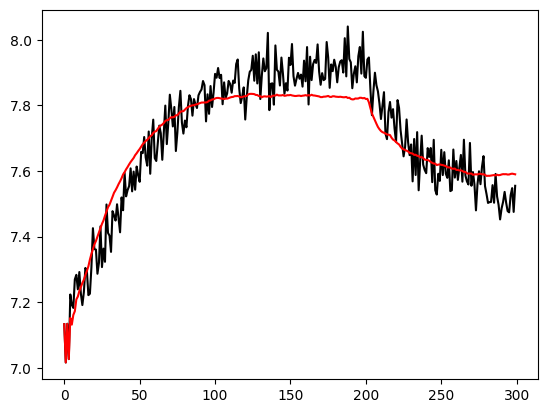

In [106]:
print(mse(Y_off, Y_pred))
plt.plot(Y_off, c='k')
plt.plot(Y_pred, c='r')

In [18]:
print(pre)

min_vals:[7.77500000e+00 5.54058448e-03 5.71566559e+00]
max_vals:[23.325       4.98602873  9.48785654]


In [19]:
with open("models/preprocessor.obj", "wb") as f:
    pickle.dump(pre, f)

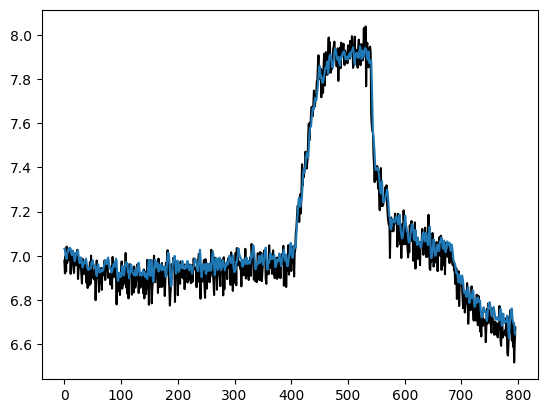

In [107]:
pid_x, pid_y = data_to_X_Y(pid11[:,1:], k)
pid_x2, pid_y2 = data_to_X_Y(pid12[:,1:], k)
pid_xfull = np.vstack([pid_x, pid_x2])
pid_yfull = np.concatenate([pid_y, pid_y2])

plt.plot(pid_yfull, c='k')
plt.plot(best_model(pre(pid_xfull)))

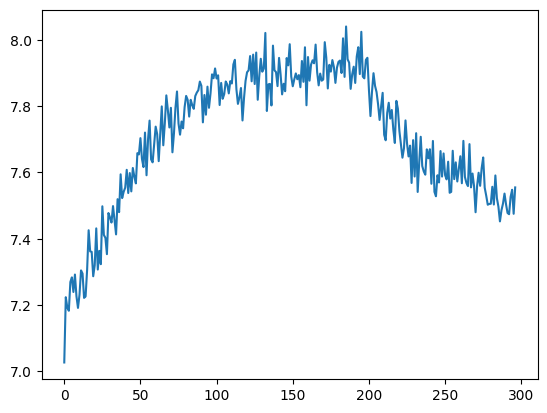

In [82]:
xtest, ytest = data_to_X_Y(test, window_size=k)

plt.plot(ytest)

In [88]:
ytest.shape

(297,)